In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

print(X_motion.shape)
print(Y_motion.shape)

(6452, 24)
(6452, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging[10]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  1.00000000e-01,
        0.00000000e+00,  0.00000000e+00,  2.23820373e-01,  1.28351569e-01,
       -3.80182743e-01,  2.57529557e-01, -1.35399371e-01, -3.75110298e-01,
       -2.40336046e-01,  1.24735124e-01, -3.85146618e-01, -2.76066184e-01,
       -1.28697008e-01, -3.81462365e-01,  1.05764173e-01, -9.22016508e-04,
        6.50531128e-02,  9.76066813e-02,  1.00000000e+00,  0.00000000e+00])

In [9]:
X_motion_FL_swinging[10, 18:22]

array([ 0.10576417, -0.00092202,  0.06505311,  0.09760668])

In [10]:
Y_motion_FL_swinging.shape

(3238, 4)

In [11]:
X_motion_FL_swinging[0:10, 0]

array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0.1])

### Linear Regression

In [13]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9877920419252909
RMSE:  0.014040178605656872
The lowest error is:  3.212260223187102e-05
The highest error is:  0.0586703710759382
The avg. error is:  0.010768910098048042


In [14]:
model_fl_relative_support_x.coef_

array([[ 1.38695149e-02,  0.00000000e+00, -8.32667268e-17,
         9.60378763e-02,  1.11022302e-16, -2.22044605e-16,
         3.96485060e-01,  3.01568056e-01, -8.49135998e-01,
         9.91224808e-02, -2.88160278e-01,  1.12293750e+00,
        -3.14905614e-01, -3.23589663e-02, -4.21877548e-01,
         6.95478287e-02]])

In [15]:
model_fl_relative_support_x.intercept_

array([0.23591961])

Text(0, 0.5, 'Predictions')

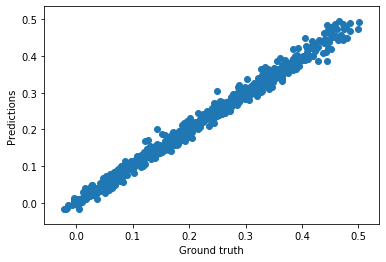

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [18]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.666068761161632
RMSE:  0.005509879045488301
The lowest error is:  6.988838530813668e-08
The highest error is:  0.02266558822747087
The avg. error is:  0.004161269501266538


In [19]:
model_fl_relative_support_y.coef_

array([[ 2.73628058e-03, -3.29597460e-17, -1.30104261e-16,
        -2.02023694e-02,  3.46944695e-17,  5.55111512e-17,
         7.90787678e-02,  9.94385822e-02,  9.49689913e-02,
        -1.29783949e+00,  1.42428827e-01,  1.89261779e-01,
        -4.03570892e-01,  3.69062175e-01, -6.50130480e-02,
        -6.76670594e-02]])

In [20]:
model_fl_relative_support_y.intercept_

array([-0.04253508])

Text(0, 0.5, 'Predictions')

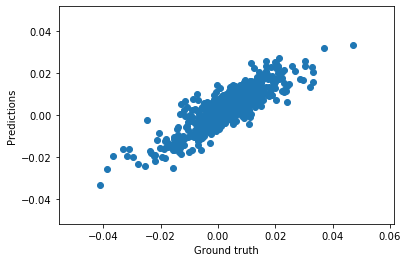

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')